# Часть 1. Проведение первичного дескриптивного анализа и модели классификации

---
Мы используем датасет с данными о факте мошенничества среди европейцев-владельцев кредитных кард в сентябре 2013 с [kaggle.com](https://www.kaggle.com/mlg-ulb/creditcardfraud/). Всего 2 признака - время и количество неизменены, остальные 28 показателей были уже так или иначе изменены с помощью PCA из-за соблюдений правил безопасности. Так как нет точной информации по каждой из синтетической переменной о ее информативности, по дефолту считаем их 100% и возможным сокращать в дальнем это количество. 




In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving creditcard.csv to creditcard (3).csv
User uploaded file "creditcard.csv" with length 150828752 bytes


In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict,cross_val_score,train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [ ]:
df = pd.read_csv('creditcard.csv')
df.shape

(284807, 31)

In [ ]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [ ]:
df.isnull().any()

Time      False
V1        False
V2        False
V3        False
V4        False
V5        False
V6        False
V7        False
V8        False
V9        False
V10       False
V11       False
V12       False
V13       False
V14       False
V15       False
V16       False
V17       False
V18       False
V19       False
V20       False
V21       False
V22       False
V23       False
V24       False
V25       False
V26       False
V27       False
V28       False
Amount    False
Class     False
dtype: bool

In [ ]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

Первичный анализ данных показывает, что выборка очень сильно несбалансирована, мошеннических транзакций было всего 0,17% от общей выборки.

In [ ]:
df['hour'] = df['Time'].apply(lambda x: round(x / 3600))

In [ ]:
df['hour'][:-20]

0          0
1          0
2          0
3          0
4          0
          ..
284782    48
284783    48
284784    48
284785    48
284786    48
Name: hour, Length: 284787, dtype: int64

In [ ]:
low = df.groupby(['hour', 'Class'])['Amount'].aggregate(['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index()
desc = pd.DataFrame(low)
desc.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']
desc.head()

,Hour,Class,Min,Max,Transactions,Sum,Mean,Median,Var
0,0,0,0.00,7712.43,2259,154937.19,68.586627,15.00,59034.248847
1,0,1,0.00,529.00,2,529.00,264.500000,264.50,139920.500000
2,1,0,0.00,2909.97,3160,191087.48,60.470722,15.97,22435.924669
3,1,1,239.93,239.93,1,239.93,239.930000,239.93,NaN
4,2,0,0.00,4002.88,1491,106292.92,71.289685,21.49,30603.434140


In [ ]:
lil = df[['Amount','Class']].copy()
real = lil.loc[lil['Class'] == 0]['Amount']
fraud = lil.loc[lil['Class'] == 1]['Amount']
fraud.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [ ]:
real.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

Интересно, что в среднем мошенническая транзакция больше настоящий, но при этом и среднее отклононение хоть и примерно одинаковое, но очевиндно, что разница в разбросах между реальными и мошенническими данными слишком высока, что может указывать на непоследотельность мошенников при переводе средств


---

Построим матрицу корреляции Пирсона между всеми признаками датасета

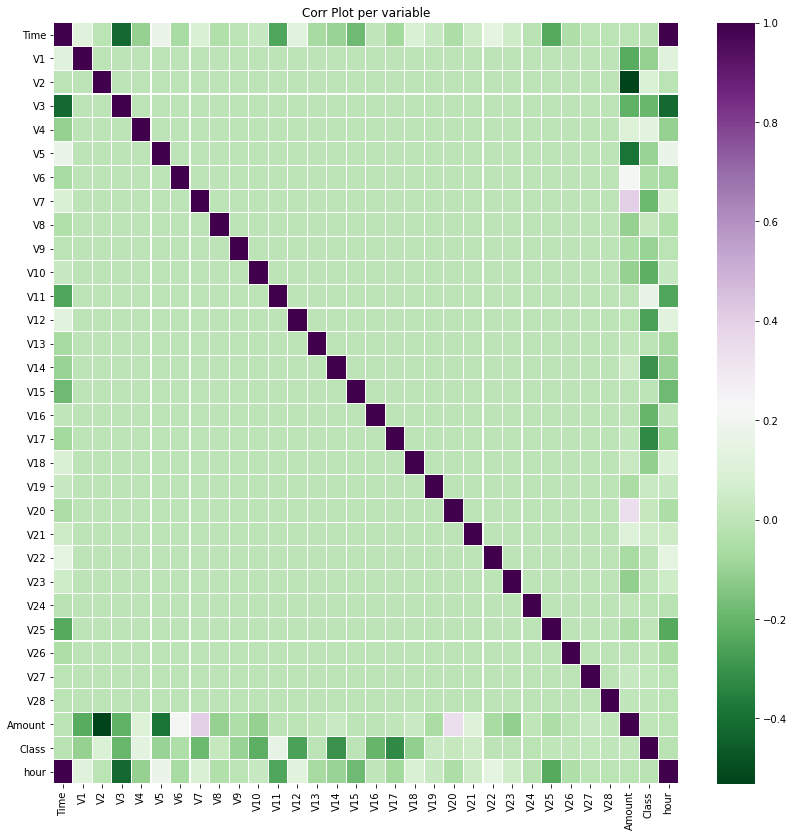

In [ ]:
plt.figure(figsize = (14,14))
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,linewidths=.1,cmap="PRGn_r")
plt.title('Corr Plot per variable')
plt.show()

Как видно из матрицы, наиболее коррелированы отрицательно с Amount V2 и V5, а позитивно - V7 И V20 

In [ ]:
y = df['Class'].values
X = df.iloc[:,1:29]
X.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, stratify=y, random_state = 22)

In [ ]:
y_new_test = np.bincount(y_test)
ii_test = np.nonzero(y_new_test)[0]
y_new_train = np.bincount(y_train)
ii_train = np.nonzero(y_new_train)[0]
np.vstack((ii_train,y_new_train[ii_train])).T

array([[     0, 227451],
       [     1,    394]])

In [ ]:
np.vstack((ii_test,y_new_test[ii_test])).T

array([[    0, 56864],
       [    1,    98]])

Арифметически можно проверить, что сплит тест отлично разделил выборку на тестовую и обучающую, учитывая пропорции между реальными данным

In [ ]:
model = LogisticRegression()
model.fit(X_train,y_train)

pred = model.predict(X_test)

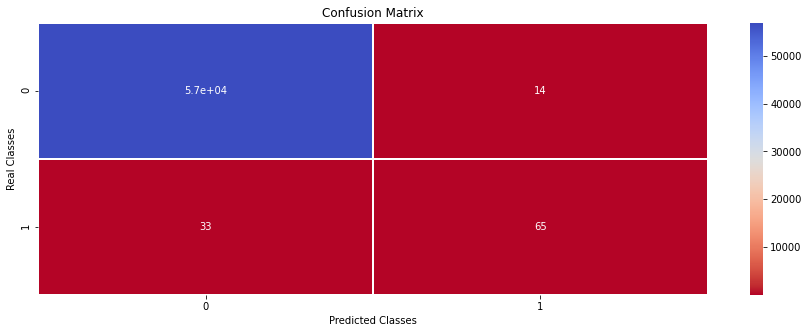

In [ ]:
cm = confusion_matrix(y_test,pred)
fig = plt.figure(figsize=(15,5))
sns.heatmap(cm,cmap='coolwarm_r',linewidths=0.5,annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Real Classes')
plt.xlabel('Predicted Classes')
plt.show()

In [ ]:
 print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.82      0.66      0.73        98

    accuracy                           1.00     56962
   macro avg       0.91      0.83      0.87     56962
weighted avg       1.00      1.00      1.00     56962



Конечно, общие результаты качества модели неплохие, но очевидно, что полагаться исключительно на матрицу неопредленностей, так как датасет очень несбалансирован, то и полагаться на эти данные не стоит

In [ ]:
model_bal = LogisticRegression(class_weight='balanced')
model_bal.fit(X_train,y_train)

pred_bal = model_bal.predict(X_test)

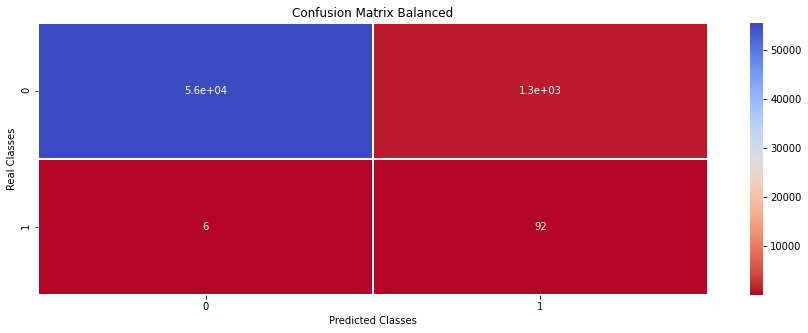

In [ ]:
cm_bal = confusion_matrix(y_test,pred_bal)
fig = plt.figure(figsize=(15,5))
sns.heatmap(cm_bal,cmap='coolwarm_r',linewidths=0.5,annot=True)
plt.title('Confusion Matrix Balanced')
plt.ylabel('Real Classes')
plt.xlabel('Predicted Classes')
plt.show()

In [ ]:
 print(classification_report(y_test,pred_bal))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.07      0.94      0.12        98

    accuracy                           0.98     56962
   macro avg       0.53      0.96      0.56     56962
weighted avg       1.00      0.98      0.99     56962



Очевидно, что результаты стали хуже. Подберем гиперпараметры для первой модели, так как все слишком хорошо на несбалансированной выборке. Посмотрим на результаты roc_auc, который способен лучше работать с подобными данными в силу своего рангового характера и добавим регуляризор L1, так как он сильнее штрафует за неверные ответы

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

In [ ]:
grid_searcher = GridSearchCV(
    LogisticRegression(max_iter=4000, solver='liblinear', random_state=22),
    param_grid={
        'C': [0.01, 0.1, 1, 10, 100, 10000],
        'penalty': ['l1']
    },
    cv=3,
    scoring='roc_auc'
)

In [ ]:
grid_searcher.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=4000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=22, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 10000],
                         'penalty': ['l1']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [ ]:
print(roc_auc_score(y_train, grid_searcher.predict_proba(X_train)[:, 1]))
print(roc_auc_score(y_test, grid_searcher.predict_proba(X_test)[:, 1]))

0.979159186113093
0.989866620536791


In [ ]:
pd.DataFrame(grid_searcher.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.903771,0.065011,0.045764,0.001264,0.01,l1,"{'C': 0.01, 'penalty': 'l1'}",0.958446,0.972223,0.979588,0.970086,0.008763,6
1,1.732633,0.307530,0.044251,0.000643,0.1,l1,"{'C': 0.1, 'penalty': 'l1'}",0.961604,0.978116,0.989824,0.976514,0.011576,1
2,4.177010,0.483004,0.045418,0.000586,1,l1,"{'C': 1, 'penalty': 'l1'}",0.952855,0.977496,0.987482,0.972611,0.014552,2
3,4.427200,0.249169,0.049457,0.005764,10,l1,"{'C': 10, 'penalty': 'l1'}",0.951506,0.976450,0.986558,0.971504,0.014731,3
4,4.407434,0.450738,0.050733,0.008141,100,l1,"{'C': 100, 'penalty': 'l1'}",0.951383,0.976328,0.986455,0.971389,0.014738,4
5,4.391758,0.421191,0.047226,0.001568,10000,l1,"{'C': 10000, 'penalty': 'l1'}",0.951373,0.976316,0.986442,0.971377,0.014737,5


In [ ]:
grid_searcher.best_params_

{'C': 0.1, 'penalty': 'l1'}

In [ ]:
grid_searcher.best_score_

0.976514430986187

В целом, мы видим, что даже на несбалансированной выборке roc_auc показывает очень хорошие усредненные результаты, особенно с гиперпараметром 0,1

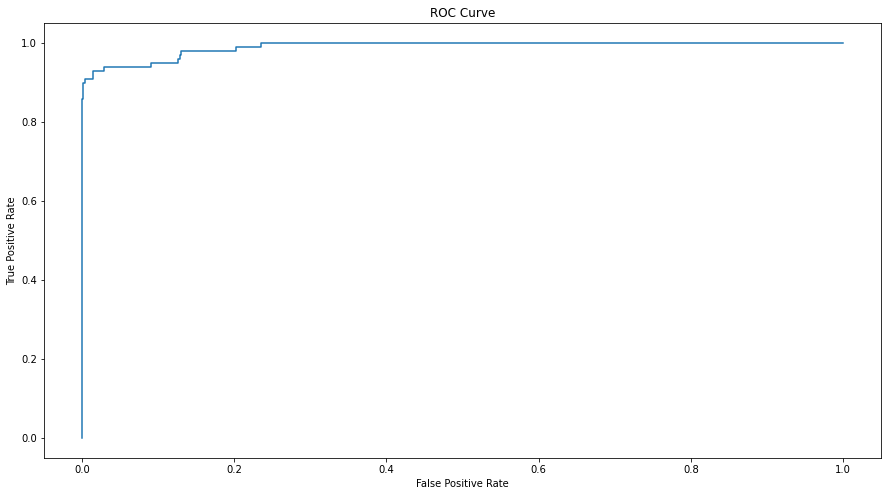

In [ ]:
fig = plt.figure(figsize=(15,8))

plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

tpr,fpr,_ = roc_curve(y_test, grid_searcher.predict_proba(X_test)[:, 1])

plt.plot(tpr,fpr)

plt.show()

# Часть 2. Сокращение размерности

---
хоть мы и знаем, что фактически датасет состоит из уже готовых PCA, но вводным данным к описанию датасета было сказано, что единственной целью данного преобразования было изменение личных данных, поэтому предположим, что эти синтетические переменные можно между собой сравнить, более того, как мы уже видели ранее они не сильно коррелированы между собой, что возможно даст неплохой результат.


In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components = 2, random_state = 0)
df_pca = pca.fit_transform(X)

In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['sample']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


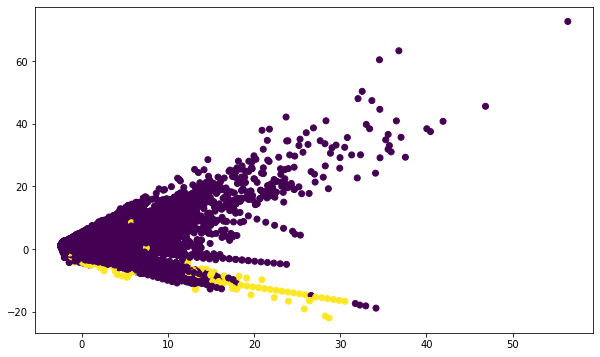

In [ ]:
pylab.figure(figsize = (10, 6))
pylab.scatter(df_pca[:, 0], df_pca[:, 1], c = y)

Очевидно, что 2 класса очень перемешаны, давайте отобразим на трехмерном пространстве

In [ ]:
pca = PCA(n_components = 3, random_state = 22)
df_pca_2 = pca.fit_transform(X)

/usr/local/lib/python3.7/dist-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


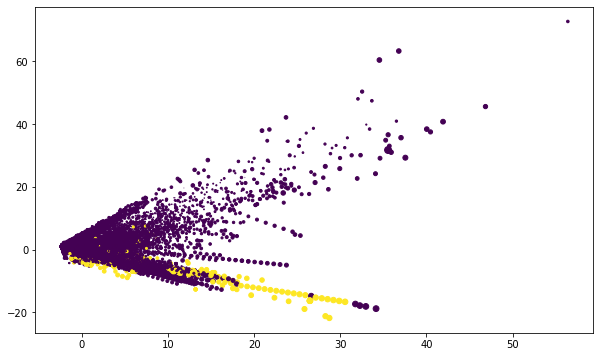

In [ ]:
pylab.figure(figsize = (10, 6))
pylab.scatter(df_pca_2[:, 0], df_pca_2[:, 1], df_pca_2[:, 2], c = y)

"сокращение" до 3 переменных методом pcа только ухудшило ситуацию. Поэтому будем считать, что лучшая модель сокращения методом pca - сокращение до 2 переменных

Рассмотрим случаи нелинейного сокращения размерности, а именно многомерное шкалирование. Для этого случайно обрежем выборку до 10000 наблюдений, чтобы сложные алгоритмы смогли себя показать

In [ ]:
from sklearn import manifold

In [ ]:
sample = df.sample(n=10000, random_state=22)
sample = sample.reset_index(drop=True)

In [ ]:
y_red = sample['Class'].values
X_red = sample.iloc[:,1:29]

In [ ]:
sample['Class'].value_counts()

0    9984
1      16
Name: Class, dtype: int64

In [ ]:
mds = manifold.MDS(n_components = 2, n_init = 1, max_iter = 1000)
df_mds = mds.fit_transform(X_red)

In [ ]:
tsne = manifold.TSNE(n_components = 2, init = 'pca', random_state = 0)
data_2d_tsne = tsne.fit_transform(X_red)